In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 필요한 라이브러리 import

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 데이터셋 불러오기 및 전처리


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/SSAC/메인 프로젝트/4조/코드/Dataset/2019 movie/rating_movie_opt1.csv')

In [ ]:
dataset = dataset[['userId','movieId','rating','timestamp', 'title']]
dataset

,userId,movieId,rating,timestamp,title
0,47684,1,3.0,942888248,Toy Story (1995)
1,57764,1,4.0,1117304440,Toy Story (1995)
2,20899,1,3.0,858198116,Toy Story (1995)
3,119478,1,3.5,1566085345,Toy Story (1995)
4,17483,1,4.0,1056054031,Toy Story (1995)
...,...,...,...,...,...
1023673,3448,201773,4.0,1564071971,Spider-Man: Far from Home (2019)
1023674,141453,201773,4.0,1569441600,Spider-Man: Far from Home (2019)
1023675,109674,201773,5.0,1565699511,Spider-Man: Far from Home (2019)
1023676,32452,201773,5.0,1569116033,Spider-Man: Far from Home (2019)


In [ ]:
dataset.columns = ['user_id','item_id','rating','timestamp', 'title']
dataset

,user_id,item_id,rating,timestamp,title
0,47684,1,3.0,942888248,Toy Story (1995)
1,57764,1,4.0,1117304440,Toy Story (1995)
2,20899,1,3.0,858198116,Toy Story (1995)
3,119478,1,3.5,1566085345,Toy Story (1995)
4,17483,1,4.0,1056054031,Toy Story (1995)
...,...,...,...,...,...
1023673,3448,201773,4.0,1564071971,Spider-Man: Far from Home (2019)
1023674,141453,201773,4.0,1569441600,Spider-Man: Far from Home (2019)
1023675,109674,201773,5.0,1565699511,Spider-Man: Far from Home (2019)
1023676,32452,201773,5.0,1569116033,Spider-Man: Far from Home (2019)


In [ ]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

유저와 영화의 수

In [ ]:
len(dataset.user_id.unique()), len(dataset.item_id.unique())

(7790, 3386)

훈련, 테스트용 데이터 분리

In [ ]:
train, test = train_test_split(dataset, test_size=0.2, random_state=4)

In [ ]:
y_true = test.rating

# 모델 생성

In [ ]:
n_latent_factors_user = 8
n_latent_factors_movie = 10
n_latent_factors_mf = 3
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding_mlp = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding-MLP')(movie_input)
movie_vec_mlp = keras.layers.Flatten(name='FlattenMovies-MLP')(movie_embedding_mlp)
movie_vec_mlp = keras.layers.Dropout(0.2)(movie_vec_mlp)

movie_embedding_mf = keras.layers.Embedding(n_movies + 1, n_latent_factors_mf, name='Movie-Embedding-MF')(movie_input)
movie_vec_mf = keras.layers.Flatten(name='FlattenMovies-MF')(movie_embedding_mf)
movie_vec_mf = keras.layers.Dropout(0.2)(movie_vec_mf)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec_mlp = keras.layers.Flatten(name='FlattenUsers-MLP')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding-MLP')(user_input))
user_vec_mlp = keras.layers.Dropout(0.2)(user_vec_mlp)

user_vec_mf = keras.layers.Flatten(name='FlattenUsers-MF')(keras.layers.Embedding(n_users + 1, n_latent_factors_mf,name='User-Embedding-MF')(user_input))
user_vec_mf = keras.layers.Dropout(0.2)(user_vec_mf)


concat = keras.layers.Concatenate(axis=1)([movie_vec_mlp, user_vec_mlp])
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat_dropout)
dense_batch = keras.layers.BatchNormalization(name='Batch')(dense)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout-1')(dense_batch)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(dropout_1)
dense_batch_2 = keras.layers.BatchNormalization(name='Batch-2')(dense_2)


dropout_2 = keras.layers.Dropout(0.2,name='Dropout-2')(dense_batch_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dropout_2)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)

pred_mf = keras.layers.Dot(axes=1)([movie_vec_mf, user_vec_mf])


pred_mlp = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)

combine_mlp_mf = keras.layers.Concatenate(axis=1)([pred_mf, pred_mlp])
result_combine = keras.layers.Dense(100,name='Combine-MF-MLP')(combine_mlp_mf)
deep_combine = keras.layers.Dense(100,name='FullyConnected-4')(result_combine)


result = keras.layers.Dense(1,name='Prediction')(deep_combine)


model = keras.Model([user_input, movie_input], result)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer='adam',loss= 'mean_absolute_error')

모델의 형태 보기

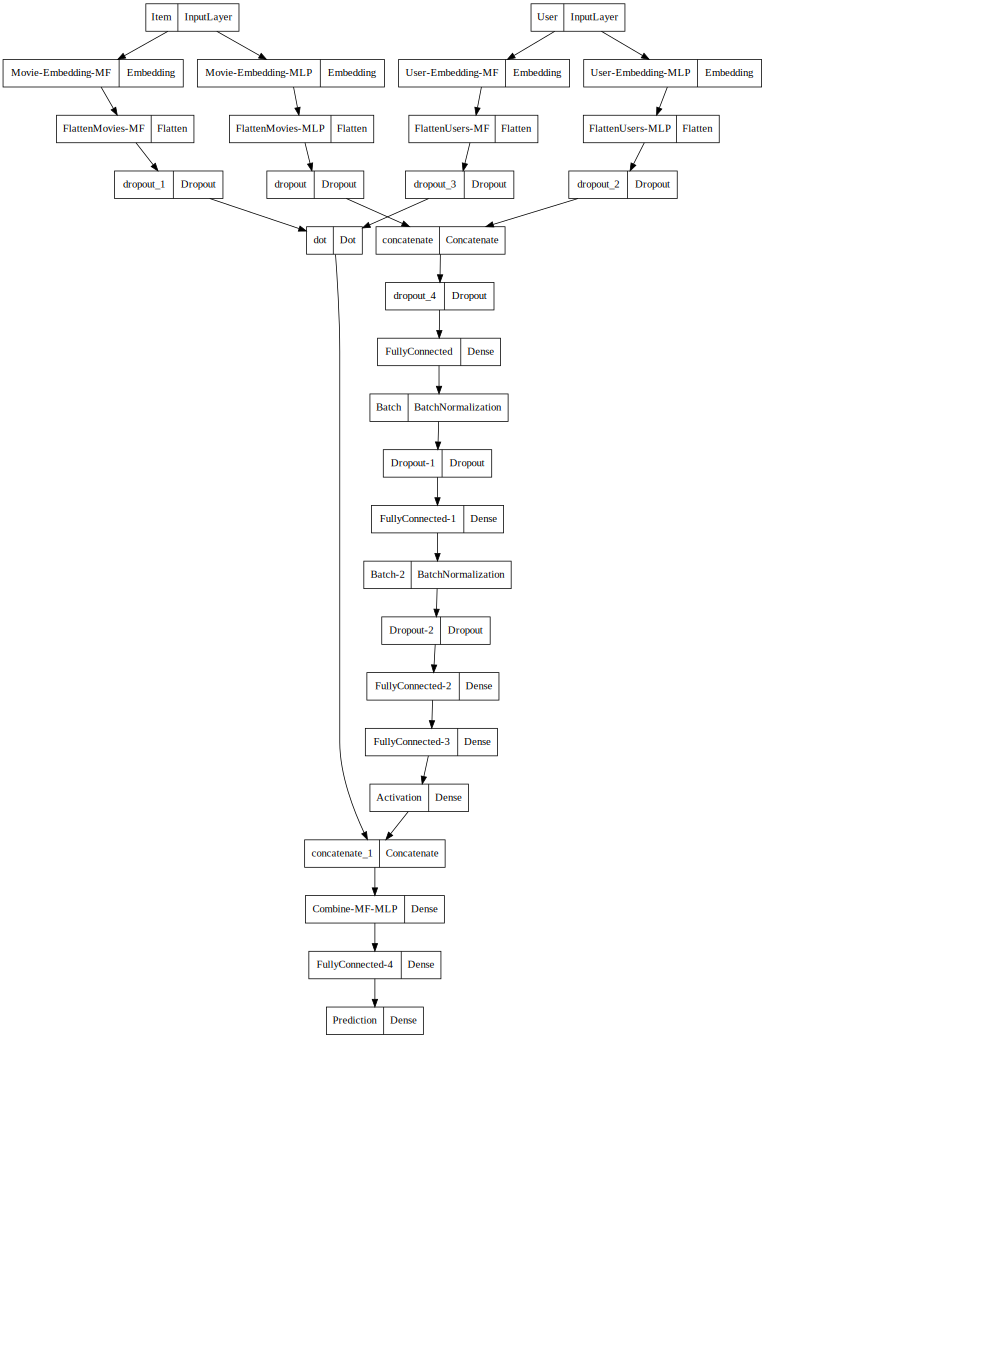

In [ ]:
SVG(model_to_dot(model,  show_shapes=False, show_layer_names=True, rankdir='HB', dpi=55).create(prog='dot', format='svg'))

모델 요약

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Item (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 User (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Movie-Embedding-MLP (Embedding  (None, 1, 10)       33870       ['Item[0][0]']                   
 )                                                                                                
                                                                                                  
 User-Embedding-MLP (Embedding)  (None, 1, 8)        62328       ['User[0][0]']               

# NCF 학습


In [ ]:
history = model.fit([train.user_id, train.item_id], train.rating, epochs=25, verbose=1, validation_split=0.1)

Epoch 1/25
23033/23033 [==============================] - 214s 9ms/step - loss: 0.7271 - val_loss: 0.6722
Epoch 2/25
23033/23033 [==============================] - 210s 9ms/step - loss: 0.6837 - val_loss: 0.6636
Epoch 3/25
23033/23033 [==============================] - 207s 9ms/step - loss: 0.6766 - val_loss: 0.6581
Epoch 4/25
23033/23033 [==============================] - 206s 9ms/step - loss: 0.6702 - val_loss: 0.6563
Epoch 5/25
23033/23033 [==============================] - 211s 9ms/step - loss: 0.6673 - val_loss: 0.6543
Epoch 6/25
23033/23033 [==============================] - 207s 9ms/step - loss: 0.6655 - val_loss: 0.6535
Epoch 7/25
23033/23033 [==============================] - 210s 9ms/step - loss: 0.6617 - val_loss: 0.6550
Epoch 8/25
23033/23033 [==============================] - 207s 9ms/step - loss: 0.6551 - val_loss: 0.6452
Epoch 9/25
23033/23033 [==============================] - 207s 9ms/step - loss: 0.6481 - val_loss: 0.6411
Epoch 10/25
23033/23033 [=====================

모델 저장

In [ ]:
model.save('/content/drive/MyDrive/SSAC/메인 프로젝트/4조/코드/Dataset/2019 movie/NCF모델.h5')

In [ ]:
m = keras.models.load_model('/content/drive/MyDrive/SSAC/메인 프로젝트/4조/코드/Dataset/2019 movie/NCF모델.h5')

training loss와 validation loss 값 변화 그래프

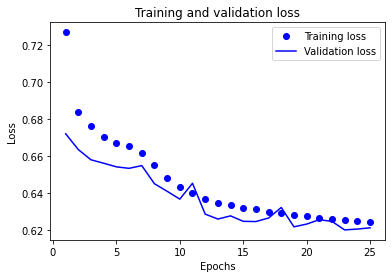

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()        # 과적합 되지 않고 잘 훈련됨

MAE와 RMSE 값

In [ ]:
y_hat_2 = np.round(model.predict([test.user_id, test.item_id]),4)
print('MAE  |', mean_absolute_error(y_true, y_hat_2))
print('RMSE |', mean_squared_error(y_true, y_hat_2)**0.5)


MAE  | 0.6493768628634845
RMSE | 0.8597838731122989


In [ ]:
test['pred'] = y_hat_2
test

,user_id,item_id,rating,timestamp,title,pred
840534,1244,2492,4.0,1296167112,Ice Age 2: The Meltdown (2006),3.9117
848498,2221,2519,3.0,1461525986,Pirates of the Caribbean: Dead Man's Chest (2006),3.2804
627735,2661,1651,2.0,1568118157,Little Nicky (2000),2.8727
118358,4370,230,4.0,859706683,"Client, The (1994)",3.6076
737836,646,2058,5.0,1100905183,Bend It Like Beckham (2002),3.6597
...,...,...,...,...,...,...
467604,7492,1079,2.0,942237517,King Kong (1976),2.9917
572317,2152,1435,2.5,1444126427,Scent of a Woman (1992),3.7937
13904,1435,20,4.0,924568449,Get Shorty (1995),3.8837
475786,2581,1111,3.0,942264829,Cocoon (1985),3.6435


test에 있는 유저만 추출

In [ ]:
user_list = test['user_id'].unique().tolist()

유저 시청목록과 추천 리스트

In [ ]:
def print_movie_list(num):
    print('user_id : ', user_list[num])
    print()
    print('highly rated movie:')
    for i in range(5):
        print('-', train[train.user_id == user_list[num]].sort_values(by = 'rating', ascending = False)['title'][:5].tolist()[i])
    print()
    print('predicted favorite movie:')
    for i in range(5):
        print('-', test[test.user_id == user_list[num]].sort_values(by = 'pred', ascending = False)['title'][:5].tolist()[i])
    print('-------------------------------------------------------------------------------------------------------')

In [ ]:
 print_movie_list(10)

user_id :  4684

highly rated movie:
- Welcome to the Dollhouse (1995) 5.0
- Henry V (1989) 5.0
- Heavenly Creatures (1994) 5.0
- Desperado (1995) 5.0
- Relic, The (1997) 5.0

predicted favorite movie:
- Down by Law (1986) 3.91
- Trainspotting (1996) 3.89
- Princess Bride, The (1987) 3.87
- Léon: The Professional (a.k.a. The Professional) (Léon) (1994) 3.87
- Aliens (1986) 3.81
-------------------------------------------------------------------------------------------------------


In [ ]:
print_movie_list(0)

user_id :  1244

highly rated movie:
- Partly Cloudy (2009) 5.0
- Star Wars: Episode VI - Return of the Jedi (1983) 5.0
- Batman Begins (2005) 5.0
- Inception (2010) 5.0
- Breakfast Club, The (1985) 5.0

predicted favorite movie:
- Lord of the Rings: The Two Towers, The (2002) 4.14
- Star Wars: Episode V - The Empire Strikes Back (1980) 4.13
- Gladiator (1992) 4.1
- Star Wars: Episode IV - A New Hope (1977) 4.09
- Moon (2009) 4.09
-------------------------------------------------------------------------------------------------------


In [ ]:
for i in range(50):
    print_movie_list(i)

user_id :  1244

highly rated movie:
- Partly Cloudy (2009)
- Star Wars: Episode VI - Return of the Jedi (1983)
- Batman Begins (2005)
- Inception (2010)
- Breakfast Club, The (1985)

predicted favorite movie:
- Lord of the Rings: The Two Towers, The (2002)
- Star Wars: Episode V - The Empire Strikes Back (1980)
- Gladiator (1992)
- Star Wars: Episode IV - A New Hope (1977)
- Moon (2009)
-------------------------------------------------------------------------------------------------------
user_id :  2221

highly rated movie:
- Avengers: Infinity War - Part II (2019)
- The Martian (2015)
- Interstellar (2014)
- Spider-Man: Far from Home (2019)
- Inside Out (2015)

predicted favorite movie:
- Dark Knight, The (2008)
- BlacKkKlansman (2018)
- Intouchables (2011)
- War for the Planet of the Apes (2017)
- 12 Years a Slave (2013)
-------------------------------------------------------------------------------------------------------
user_id :  2661

highly rated movie:
- Cloverfield (2008)
-

# 테스트 셋과 예측 비교 - NCF

In [ ]:
for num in range(10):
    for i in range(10):
        try:
            print(f'- 유저 {user_list[num]}의' , test[test.user_id == user_list[num]]['item_id'].tolist()[i] ,'번 영화에 대한 평점 -')
            print(f'실제 : ', test[test.user_id == user_list[num]]['rating'].tolist()[i], ', 예측 : ', round( test[test.user_id == user_list[num]]['pred'].tolist()[i], 1), '\n')
        except:
            pass


- 유저 1244의 2492 번 영화에 대한 평점 -
실제 :  4.0 , 예측 :  3.9 

- 유저 1244의 2159 번 영화에 대한 평점 -
실제 :  3.5 , 예측 :  4.1 

- 유저 1244의 2261 번 영화에 대한 평점 -
실제 :  5.0 , 예측 :  3.8 

- 유저 1244의 1124 번 영화에 대한 평점 -
실제 :  4.0 , 예측 :  3.8 

- 유저 1244의 2314 번 영화에 대한 평점 -
실제 :  3.0 , 예측 :  3.9 

- 유저 1244의 627 번 영화에 대한 평점 -
실제 :  3.5 , 예측 :  4.0 

- 유저 1244의 530 번 영화에 대한 평점 -
실제 :  4.0 , 예측 :  4.0 

- 유저 1244의 2368 번 영화에 대한 평점 -
실제 :  3.5 , 예측 :  3.9 

- 유저 1244의 2628 번 영화에 대한 평점 -
실제 :  5.0 , 예측 :  4.0 

- 유저 1244의 2124 번 영화에 대한 평점 -
실제 :  3.5 , 예측 :  3.9 

- 유저 2221의 2519 번 영화에 대한 평점 -
실제 :  3.0 , 예측 :  3.3 

- 유저 2221의 3034 번 영화에 대한 평점 -
실제 :  4.0 , 예측 :  3.5 

- 유저 2221의 2845 번 영화에 대한 평점 -
실제 :  2.5 , 예측 :  3.2 

- 유저 2221의 2894 번 영화에 대한 평점 -
실제 :  3.5 , 예측 :  3.3 

- 유저 2221의 3132 번 영화에 대한 평점 -
실제 :  3.5 , 예측 :  3.5 

- 유저 2221의 3213 번 영화에 대한 평점 -
실제 :  4.0 , 예측 :  3.6 

- 유저 2221의 3194 번 영화에 대한 평점 -
실제 :  3.5 , 예측 :  3.4 

- 유저 2221의 3081 번 영화에 대한 평점 -
실제 :  3.5 , 예측 :  3.4 

- 유저 2221의 2697 번 영화에 대한 평점 -
